Read csv output from TeukEvolution.jl

# Load packages

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import glob
from matplotlib.colors import LogNorm
from scipy.special import roots_legendre,sph_harm,eval_jacobi
factorial = np.math.factorial

# Load data

In [114]:
a=0.7
#Dirs = glob.glob("../data/TeukEvolution/pure_qnm/high_a%s_n3/"%a)#_11_51_05_m0.5_s0.0_nx220_nl16/")#*s0.499*/
#Dirs = glob.glob("../data/TeukEvolution/scattering/high_a%s_scattering/"%a)#_11_51_05_m0.5_s0.0_nx220_nl16/")#*s0.499*/
Dirs = glob.glob("../data/TeukEvolution/multi_qnm/a%s_mult_qnm/"%a)

In [115]:
Dir = Dirs[0]

In [116]:
Dir

'../data/TeukEvolution/multi_qnm/a0.7_mult_qnm/'

## 2D data

### Load field 
(this might take half a minute)

In [117]:
Amp10_22_re = []
Amp10_22_im = []
time = []
with open(Dir+'lin_f_re_2.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',',quotechar='|')
    for row in spamreader:
        Amp10_22_re.append(np.genfromtxt(np.array(row[3:-1])))#,dtype="float"))
        nx = int(row[1])
        ny = int(row[2])
        time.append(row[0])
time = np.array(time,dtype='float')
Amp10_22_re = np.array(Amp10_22_re,dtype='float')

with open(Dir+'lin_f_im_2.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',',quotechar='|')
    for row in spamreader:
        Amp10_22_im.append(np.genfromtxt(np.array(row[3:-1])))#,dtype="float"))
Amp10_22_im = np.array(Amp10_22_im,dtype='float')
psi4=Amp10_22_re+1j*Amp10_22_im

### Load derivative

In [118]:

Amp10_22_re = []
Amp10_22_im = []
time = []
with open(Dir+'lin_p_re_2.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',',quotechar='|')
    for row in spamreader:
        Amp10_22_re.append(np.genfromtxt(np.array(row[3:-1])))#,dtype="float"))
        time.append(row[0])
time = np.array(time,dtype='float')
Amp10_22_re = np.array(Amp10_22_re)

with open(Dir+'lin_p_im_2.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',',quotechar='|')
    for row in spamreader:
        Amp10_22_im.append(np.genfromtxt(np.array(row[3:-1])))
Amp10_22_im = np.array(Amp10_22_im)
dt_psi4=Amp10_22_re+1j*Amp10_22_im


reshape the arrays to $[t,r,\theta]$

In [119]:
psi4 = psi4.reshape(time.shape[0],nx,ny)
dt_psi4 = dt_psi4.reshape(time.shape[0],nx,ny)

# Decompose data into spherical harmonics

## Useful functions for spin-weighted spherical harmonics

In [120]:
def inner_product(v1,v2):
    ny = v1.shape[-1]
    rs,ws = roots_legendre(ny)
    s = np.einsum("ijk,k,k->ij",v1,v2,ws)
    return(s)

In [121]:
def swal(s,l,m,y):
    if l<m:
        return("Error: l<m")
    a = int(np.abs(m-s))
    b = int(np.abs(m+s))
    n = l - (a+b)/2
    if n < 0:
        return np.zeros(y.shape[0])
    norm = np.sqrt(
        (2 * n + a + b + 1) * (2**(-a - b - 1.0)) * factorial(n + a + b) /
        factorial(n + a) * factorial(n) / factorial(n + b),
    )
    norm *= (-1)**(max(m, -s))
    #print(a)
    return norm * ((1 - y)**(a / 2.0)) * ((1 + y)**(b / 2.0)) * eval_jacobi(n, a, b, y)

In [122]:
def decompose(data,s,l,m,y):
    v2 = swal(s,l,m,y)
    return inner_product(data,v2)

In [123]:
s = -2
m = 2
y, w = roots_legendre(ny)

In [124]:
ls = range(2,12)
psi4_l = []
for l in ls:
    psi4_l.append(decompose(psi4,s,l,m,y))
psi4_l = np.array(psi4_l)

ls = range(2,12)
dt_psi4_l = []
for l in ls:
    dt_psi4_l.append(decompose(dt_psi4,s,l,m,y))
dt_psi4_l = np.array(dt_psi4_l)

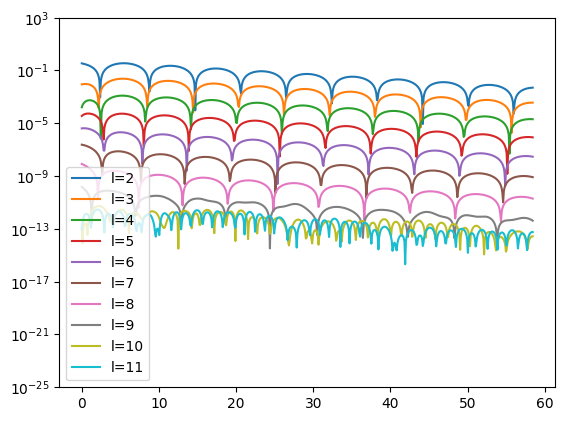

In [125]:
i=0
for l in ls:
    plt.plot(time,np.abs(np.real(psi4_l[i][:,-1])),label='l=%s'%l)
    i+=1

plt.ylim(1e-25,1e3)
plt.yscale('log')
plt.legend()

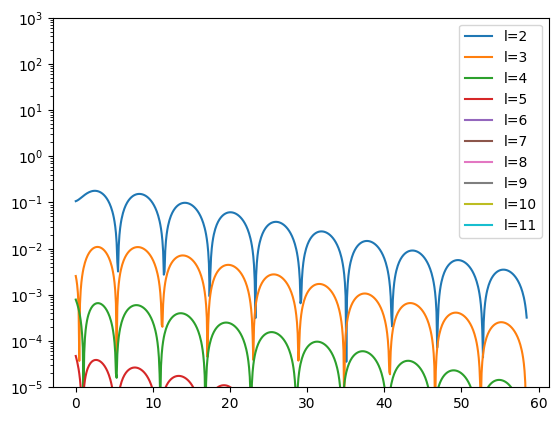

In [126]:
i=0
for l in ls:
    plt.plot(time,np.abs(np.real(dt_psi4_l[i][:,-1])),label='l=%s'%l)
    i+=1

plt.ylim(1e-5,1e3)
plt.yscale('log')
plt.legend()

In [127]:
# reevaluate radial coordinate
if a ==0:
    rmax = 0.5
else:
    rmax = (1 / (a**2)) * (1 - np.sqrt(1 - ((a)**2)))
r = np.linspace(0,rmax,nx)

In [128]:
np.savez(Dir+"/a%s_nx%s_ny%s.npz"%(a,nx,ny),
            spin = 0,
            psi4 = np.sum(psi4_l,axis=0),dt_psi4 = np.sum(dt_psi4_l,axis=0),time = time,rads = r, 
             psi4_l = psi4_l, dt_psi4_l = dt_psi4_l)
            #psi4_source44 = psi4_source44_int[i],psi4_44=psi4_44_int[i])